In [43]:
import warnings
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.svm import SVC
warnings.simplefilter('ignore')
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import r2_score

In [44]:
df_t=pd.read_csv("train.csv")
df_t['일시']= df_t['일시'].astype('str')
df_t['일시']=pd.to_datetime(df_t['일시'])
df_t['광진구']=df_t['광진구']*1000
df_t['동대문구']=df_t['동대문구']*1000
df_t['성동구']=df_t['성동구']*1000
df_t['중랑구']=df_t['중랑구']*1000

In [45]:
data = pd.read_csv("data.csv")
data.drop('Unnamed: 0', axis=1, inplace=True)
data['일시']= data['일시'].astype('str')
data['일시']=pd.to_datetime(data['일시'])

In [46]:
df = pd.merge(df_t, data, how='outer',on='일시')

In [47]:
df['년']=pd.to_datetime(df['일시']).dt.year
df['월']=pd.to_datetime(df['일시']).dt.month
df['일']=pd.to_datetime(df['일시']).dt.day
df['요일'] = pd.to_datetime(df['일시']).dt.weekday
df.loc[((df['월'] <= 3)) , '계절'] = 0
df.loc[((df['월'] > 3) & (df['월'] <= 6)) , '계절'] = 1
df.loc[((df['월'] > 6) & (df['월'] <= 9)) , '계절'] = 2
df.loc[((df['월'] > 9) & (df['월'] <= 12)) , '계절'] = 3

In [48]:
import holidays
holiday_list = pd.date_range(start='2018-01-01', end='2021-12-31', freq='D')
kr_holidays = holidays.KR()
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(holiday_list)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1.0 if x in kr_holidays else 0.0)
holiday_df.rename(columns = {'ds':'일시', 'holiday':'휴일'}, inplace = True)


In [49]:
df = pd.merge(df, holiday_df, how='outer',on='일시')
df

,일시,광진구,동대문구,성동구,중랑구,광진구오존,광진구미세먼지,동대문구오존,동대문구미세먼지,성동구오존,...,습도,여름체감,가입 수,확진자,년,월,일,요일,계절,휴일
0,2018-01-01,592.0,368.0,580000.0,0.162,0.012,42.0,0.013,46.0,0.009,...,0.0,0.0,302.0,0.0,2018,1,1,0,0.0,1.0
1,2018-01-02,840.0,614.0,1034000.0,0.260,0.011,43.0,0.012,43.0,0.009,...,0.0,0.0,246.0,0.0,2018,1,2,1,0.0,0.0
2,2018-01-03,828.0,576.0,952000.0,0.288,0.017,34.0,0.017,37.0,0.014,...,0.0,0.0,205.0,0.0,2018,1,3,2,0.0,0.0
3,2018-01-04,792.0,542.0,914000.0,0.292,0.014,44.0,0.010,48.0,0.008,...,0.0,0.0,169.0,0.0,2018,1,4,3,0.0,0.0
4,2018-01-05,818.0,602.0,994000.0,0.308,0.008,64.0,0.009,65.0,0.006,...,0.0,0.0,183.0,0.0,2018,1,5,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2021-12-27,3830.0,3416.0,2908000.0,2.350,0.011,23.0,0.008,30.0,0.007,...,0.0,0.0,229.0,78.0,2021,12,27,0,3.0,0.0
1457,2021-12-28,4510.0,3890.0,3714000.0,2.700,0.003,42.0,0.003,51.0,0.002,...,0.0,0.0,291.0,77.0,2021,12,28,1,3.0,0.0
1458,2021-12-29,4490.0,3524.0,3660000.0,2.524,0.008,54.0,0.010,65.0,0.009,...,0.0,0.0,337.0,180.0,2021,12,29,2,3.0,0.0
1459,2021-12-30,4444.0,3574.0,3530000.0,2.506,0.022,26.0,0.027,26.0,0.025,...,0.0,0.0,283.0,113.0,2021,12,30,3,3.0,0.0


In [50]:
from sklearn.preprocessing import StandardScaler

df_num = df[['광진구오존', '광진구미세먼지', '동대문구오존',
       '동대문구미세먼지', '성동구오존', '성동구미세먼지', '중랑구오존', '중랑구미세먼지', '광진구유동인구',
       '동대문구유동인구', '성동구유동인구', '중랑구유동인구', '강수량', '겨울기온', '풍속', '겨울체감', '여름기온',
       '습도', '여름체감', '가입 수', '확진자', '요일', '년', '월', '일', '계절', '휴일']]
sc = StandardScaler()
df_num_sc = sc.fit_transform(df_num)
df_num_sc = pd.DataFrame(df_num_sc, columns=df_num.columns)
df_sc = pd.concat([df_num_sc, df[['일시', '광진구', '동대문구', '성동구', '중랑구']]], axis=1)

# 광진구 예측

In [51]:
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib as mat
#한글폰트 나눔스퀘어 지정
mat.rcParams['font.family'] = 'NanumSquare'

In [52]:
df2=df_sc.drop(['동대문구오존','동대문구미세먼지','성동구오존','성동구미세먼지','중랑구오존','중랑구미세먼지',
              '동대문구유동인구','성동구유동인구','중랑구유동인구','동대문구','성동구','중랑구'],axis=1)

df3 = df2.set_index('일시')

split = "2021-01-01"

df_train = df3[:split]
df_test = df3[split:]

df_train_y = df_train.loc[:,'광진구']
df_train_x = df_train.drop('광진구', axis=1)
df_test_y = df_test.loc[:,'광진구']
df_test_x = df_test.drop('광진구', axis=1)

df_test_orig = df_test.loc[:, ['광진구']]

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [54]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

In [55]:
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

lr_reg = LinearRegression()
ridge_reg = Ridge(random_state = 2022, alpha=10)
lasso_reg = Lasso(random_state = 2022, alpha=0.001)
rf_reg = RandomForestRegressor(random_state = 2022, n_estimators=500)
gbm_reg = GradientBoostingRegressor(random_state = 2022, n_estimators=500)
xgb_reg = XGBRegressor(random_state = 2022, n_estimators=500)
lgbm_reg = LGBMRegressor(random_state = 2022, n_estimators=500)

In [56]:
for model in [lr_reg,ridge_reg, lasso_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,df_train_x, df_test_x, df_train_y, df_test_y,is_expm1=True)

### LinearRegression ###
RMSLE: 0.287, RMSE: 1769.972, MAE: 1420.993
### Ridge ###
RMSLE: 0.282, RMSE: 1747.716, MAE: 1400.362
### Lasso ###
RMSLE: 0.286, RMSE: 1757.108, MAE: 1409.937
### RandomForestRegressor ###
RMSLE: 0.607, RMSE: 3462.542, MAE: 2904.578
### GradientBoostingRegressor ###
RMSLE: 0.598, RMSE: 3815.812, MAE: 3276.235
### XGBRegressor ###
RMSLE: 0.599, RMSE: 3630.728, MAE: 3073.640
### LGBMRegressor ###
RMSLE: 0.578, RMSE: 3625.215, MAE: 3062.122


# Feature Selection

<AxesSubplot:>

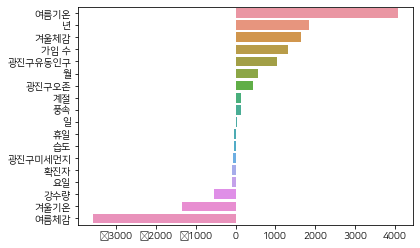

In [57]:
coef = pd.Series(lr_reg.coef_, index=df_train_x.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

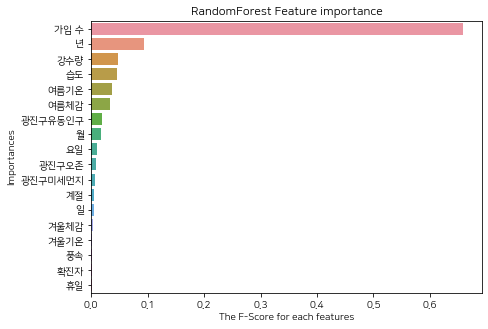

In [58]:
imp = rf_reg.feature_importances_
imp_seri = pd.Series(imp, index = df_train_x.columns)
imp_seri = imp_seri.sort_values(ascending=False)

plt.figure(figsize=(7,5))
sns.barplot(x = imp_seri, y = imp_seri.index)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.title('RandomForest Feature importance')
plt.show()

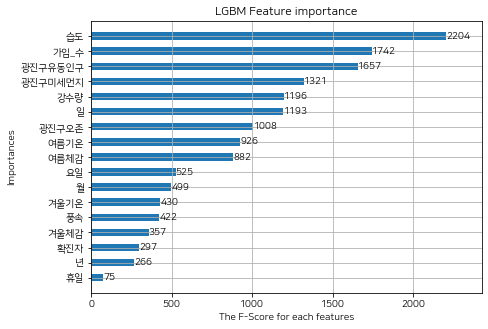

In [59]:
from lightgbm import plot_importance as lgbm_plot

fig, ax_lgbm = plt.subplots(figsize=(7,5))
lgbm_plot(lgbm_reg, ax=ax_lgbm, height = 0.5, grid = True)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.title('LGBM Feature importance')
plt.show()

In [60]:
df_fs = df_sc.loc[:,['광진구', '여름기온', '겨울체감', '년', '가입 수', 
                     '광진구유동인구', '강수량', '겨울기온', '여름체감', '일시']]

df_fs = df_fs.set_index('일시')

split = "2021-01-01"

df_fs_train = df_fs[:split]
df_fs_test = df_fs[split:]

df_fs_train_y = df_fs_train.loc[:,'광진구']
df_fs_train_x = df_fs_train.drop('광진구', axis=1)
df_fs_test_y = df_fs_test.loc[:,'광진구']
df_fs_test_x = df_fs_test.drop('광진구', axis=1)

df_fs_test_orig = df_fs_test.loc[:, ['광진구']]

In [61]:
for model in [lr_reg,ridge_reg, lasso_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,df_fs_train_x, df_fs_test_x, df_fs_train_y, df_fs_test_y,is_expm1=True)

### LinearRegression ###
RMSLE: 0.346, RMSE: 2277.244, MAE: 1845.729
### Ridge ###
RMSLE: 0.359, RMSE: 2418.226, MAE: 1963.020
### Lasso ###
RMSLE: 0.346, RMSE: 2277.268, MAE: 1845.748
### RandomForestRegressor ###
RMSLE: 0.647, RMSE: 3738.680, MAE: 3053.793
### GradientBoostingRegressor ###
RMSLE: 0.580, RMSE: 3669.166, MAE: 3058.775
### XGBRegressor ###
RMSLE: 0.642, RMSE: 3694.380, MAE: 3049.654
### LGBMRegressor ###
RMSLE: 0.654, RMSE: 3903.001, MAE: 3218.946


# Parameter Tunning

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

parameters_rf = {
     'n_estimators': [10, 20, 50,100,150,200],
     'max_depth' : [None,5,10, 15, 20],
    'min_samples_leaf' : [0.01, 0.1, 0.2, 0.4, 0.7, 0.8, 1],
    'min_samples_split' : [2,5,7]
}

clf_rf = GridSearchCV(rf_reg, param_grid=parameters_rf, cv = 5, scoring = "roc_auc", n_jobs = -1, verbose = 2)
clf_rf.fit(df_train_x, df_train_y)
get_model_predict(rf_reg,df_train_x, df_test_x, df_train_y, df_test_y,is_expm1=True)
print("Best Estimator: {}".format(clf_rf.best_estimator_))

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
### RandomForestRegressor ###
RMSLE: 0.607, RMSE: 3462.542, MAE: 2904.578
Best Estimator: RandomForestRegressor(min_samples_leaf=0.01, n_estimators=10, random_state=2022)


In [63]:
parameters_gbm = {
    'random_state':[2022],
     'n_estimators': [1,10,20,50,100],
     'learning_rate': [ 0.0001, 0.001,0.01,0.1,1]
}

clf_gbm = GridSearchCV(gbm_reg, param_grid=parameters_gbm, cv = 5, scoring = "roc_auc", n_jobs = -1, verbose = 2)
clf_gbm.fit(df_train_x, df_train_y)
get_model_predict(gbm_reg,df_train_x, df_test_x, df_train_y, df_test_y,is_expm1=True)
print("Best Estimator: {}".format(clf_gbm.best_estimator_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
### GradientBoostingRegressor ###
RMSLE: 0.598, RMSE: 3815.812, MAE: 3276.235
Best Estimator: GradientBoostingRegressor(learning_rate=0.0001, n_estimators=1,
                          random_state=2022)


In [64]:
parameters_lgbm = {
    'random_state':[2022],
     'objective':['binary'],
    'metric':['binary_logloss'],
    'learning_rate':[0.001,0.01, 0.1],
    'n_estimators': [1,10,20,50,100, 150, 200, 500],
    'max_depth':[-1,1,3,5],
    'num_iterations':[10, 50, 100,1000,2000]
}

clf_lgbm = GridSearchCV(lgbm_reg, param_grid=parameters_lgbm, cv = 5, scoring = "roc_auc", n_jobs = -1, verbose = 2)
clf_lgbm.fit(df_train_x, df_train_y)
get_model_predict(lgbm_reg,df_train_x, df_test_x, df_train_y, df_test_y,is_expm1=True)
print("Best Estimator: {}".format(clf_lgbm.best_estimator_))

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
### LGBMRegressor ###
RMSLE: 0.578, RMSE: 3625.215, MAE: 3062.122
Best Estimator: LGBMRegressor(learning_rate=0.001, metric='binary_logloss', n_estimators=1,
              num_iterations=10, objective='binary', random_state=2022)


# 예측 결과 혼합

In [65]:
ridge_reg = Ridge(random_state = 2022, alpha=8)
ridge_reg.fit(df_train_x, df_train_y)
lasso_reg = Lasso(random_state = 2022, alpha=0.001)
lasso_reg.fit(df_train_x, df_train_y)
lr_reg = LinearRegression()
lr_reg.fit(df_train_x, df_train_y)


ridge_pred = ridge_reg.predict(df_test_x)
lasso_pred = lasso_reg.predict(df_test_x)
lr_pred = lr_reg.predict(df_test_x)

pred = 0.6 * ridge_pred + 0.4 * lr_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lr_pred}

evaluate_regr(df_test_y,pred)

RMSLE: 0.283, RMSE: 1750.844, MAE: 1403.716


In [66]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(df_train_x, df_train_y)
lgbm_reg.fit(df_train_x, df_train_y)
xgb_pred = xgb_reg.predict(df_test_x)
lgbm_pred = lgbm_reg.predict(df_test_x)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
  
evaluate_regr(df_test_y,pred)

RMSLE: 0.519, RMSE: 3524.800, MAE: 2992.743


<AxesSubplot:xlabel='일시'>

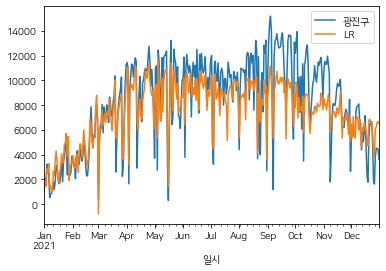

In [67]:
lr_reg = LinearRegression()
lr_reg.fit(df_train_x, df_train_y)
pred = lr_reg.predict(df_test_x)

result = pd.concat([df_test_orig.reset_index(), pd.DataFrame(pred, columns=['LR'])], axis=1, ignore_index=False)
result = result.set_index('일시')
result = result.loc[:, ['광진구', 'LR']]
result.plot()

# 인사이트

<AxesSubplot:xlabel='일시'>

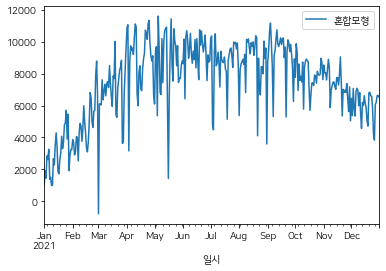

In [68]:
result = pd.concat([df_test_orig.reset_index(), pd.DataFrame(pred, columns=['혼합모형'])], axis=1, ignore_index=False)
result = result.set_index('일시')
result = result.loc[:, ['혼합모형']]
result.plot()

<AxesSubplot:xlabel='일시'>

<Figure size 3600x72000 with 0 Axes>

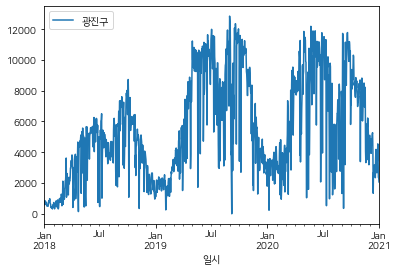

In [69]:
df3 = df.set_index('일시')

split = "2021-01-01"

data = df3[:split]
result = data.loc[:, ['광진구']]
plt.figure(figsize=(50,1000))
result.plot()

In [70]:
df2=df.drop(['동대문구오존','동대문구미세먼지','성동구오존','성동구미세먼지','중랑구오존','중랑구미세먼지',
              '동대문구유동인구','성동구유동인구','중랑구유동인구','동대문구','성동구','중랑구'],axis=1)

df3 = df2.set_index('일시')

split = "2021-01-01"

df_train = df3[:split]
df_test = df3[split:]

df_train_y = df_train.loc[:,'광진구']
df_train_x = df_train.drop('광진구', axis=1)
df_test_y = df_test.loc[:,'광진구']
df_test_x = df_test.drop('광진구', axis=1)

df_test_orig = df_test.loc[:, ['광진구']]

fin = pd.concat([df_test_x.reset_index(), pd.DataFrame(pred, columns=['예측결과'])], axis=1, ignore_index=False)
fin

,일시,광진구오존,광진구미세먼지,광진구유동인구,강수량,겨울기온,풍속,겨울체감,여름기온,습도,여름체감,가입 수,확진자,년,월,일,요일,계절,휴일,예측결과
0,2021-01-01,0.011,25.0,103938.0,0.0,-9.3,11.2,-14.8,1.6,52.8,2.9,758.0,133.0,2021,1,1,4,0.0,1.0,1045.319764
1,2021-01-02,0.020,29.0,159088.0,0.0,-6.4,19.1,-13.2,-1.4,31.4,-0.4,629.0,24.0,2021,1,2,5,0.0,0.0,1918.076282
2,2021-01-03,0.014,35.0,131982.0,0.0,-7.8,14.4,-13.9,-2.0,32.5,-0.9,584.0,16.0,2021,1,3,6,0.0,0.0,1449.228032
3,2021-01-04,0.007,34.0,280624.0,0.0,-8.1,14.0,-14.2,0.3,41.5,1.4,493.0,130.0,2021,1,4,0,0.0,0.0,2848.494626
4,2021-01-05,0.018,23.0,284649.0,0.0,-7.7,23.0,-15.5,-2.1,72.5,0.0,312.0,12.0,2021,1,5,1,0.0,0.0,2615.557140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2021-12-27,0.011,23.0,332162.0,0.0,-12.2,14.0,-19.2,0.0,0.0,0.0,229.0,78.0,2021,12,27,0,3.0,0.0,6062.050003
361,2021-12-28,0.003,42.0,347442.0,0.0,-8.3,11.9,-13.8,0.0,0.0,0.0,291.0,77.0,2021,12,28,1,3.0,0.0,6210.082908
362,2021-12-29,0.008,54.0,359176.0,0.2,-3.7,8.3,-7.2,0.0,0.0,0.0,337.0,180.0,2021,12,29,2,3.0,0.0,6614.414146
363,2021-12-30,0.022,26.0,377097.0,0.0,-5.4,25.2,-12.9,0.0,0.0,0.0,283.0,113.0,2021,12,30,3,3.0,0.0,6633.555931


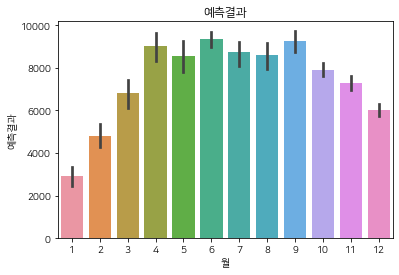

In [71]:
sns.barplot(data = fin, x='월', y='예측결과')
plt.title('예측결과')
plt.show()

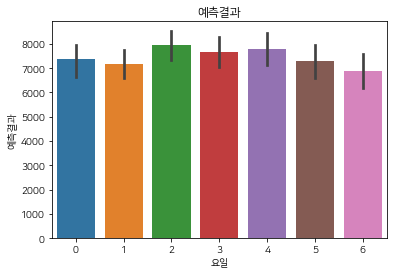

In [72]:
sns.barplot(data = fin, x='요일', y='예측결과')
plt.title('예측결과')
plt.show()

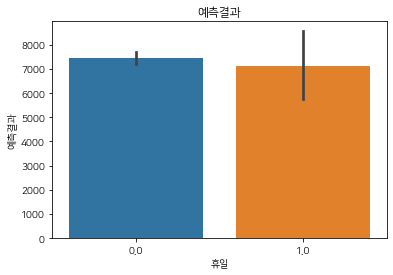

In [73]:
sns.barplot(data = fin, x='휴일', y='예측결과')
plt.title('예측결과')
plt.show()

<AxesSubplot:>

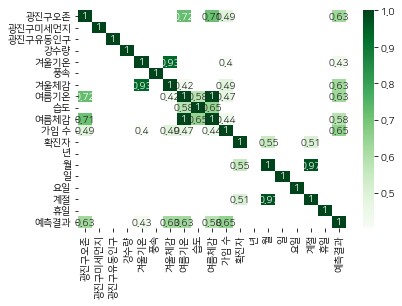

In [74]:
import matplotlib as mat
#한글폰트 나눔스퀘어 지정
plt.rcParams['font.family'] = 'NanumSquare'

df_clear_corr=fin.corr()
kot = df_clear_corr[df_clear_corr>=.4]
#sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(kot, annot=True, cmap="Greens")

In [80]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=2022)
fin3 = fin.set_index('일시')
sc = StandardScaler()
fin4 = sc.fit_transform(fin3)
fin5 = pd.DataFrame(fin4, columns=fin3.columns)

clusters = kmeans.fit(fin5)

fin5['cluster'] = clusters.labels_
fin5.head()

,광진구오존,광진구미세먼지,광진구유동인구,강수량,겨울기온,풍속,겨울체감,여름기온,습도,여름체감,가입 수,확진자,년,월,일,요일,계절,휴일,예측결과,cluster
0,-1.123065,-0.320052,-3.166009,-0.304998,-2.092429,0.438054,-2.102875,-1.069889,0.429736,-1.005026,-0.860040,1.429640,0.0,-1.602745,-1.673503,0.499144,-1.351749,4.267379,-2.658542,4
1,-0.448117,-0.211459,-2.315151,-0.304998,-1.469409,1.349401,-1.847870,-1.306758,-0.321903,-1.264941,-0.959383,-0.247343,0.0,-1.602745,-1.559818,0.999659,-1.351749,-0.234336,-2.296373,4
2,-0.898082,-0.048569,-2.733344,-0.304998,-1.770177,0.807207,-1.959435,-1.354132,-0.283267,-1.304322,-0.994038,-0.370424,0.0,-1.602745,-1.446134,1.500174,-1.351749,-0.234336,-2.490932,4
3,-1.423042,-0.075718,-0.440084,-0.304998,-1.834627,0.761063,-2.007249,-1.172532,0.032843,-1.123169,-1.064117,1.383484,0.0,-1.602745,-1.332449,-1.502916,-1.351749,-0.234336,-1.910276,4
4,-0.598105,-0.374348,-0.377986,-0.304998,-1.748694,1.799306,-2.214440,-1.362027,1.121665,-1.233436,-1.203505,-0.431965,0.0,-1.602745,-1.218764,-1.002401,-1.351749,-0.234336,-2.006938,4


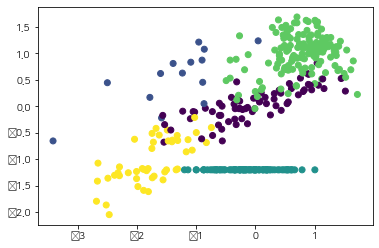

In [81]:
plt.scatter(fin5['예측결과'], fin5['여름기온'], c=fin5['cluster'])

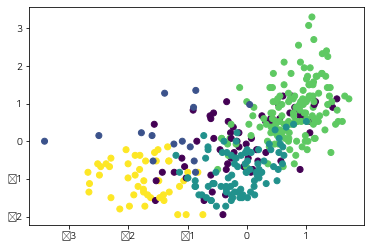

In [82]:
plt.scatter(fin5['예측결과'], fin5['광진구오존'], c=fin5['cluster'])

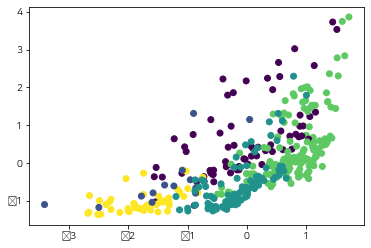

In [83]:
plt.scatter(fin5['예측결과'], fin5['가입 수'], c=fin5['cluster'])

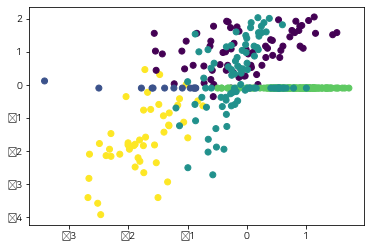

In [84]:
plt.scatter(fin5['예측결과'], fin5['겨울기온'], c=fin5['cluster'])